In [1]:
!pip install --quiet vit-keras
!pip install tensorflow_addons

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 6.6 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Using our merged dataset train & test data

This Task is (SEB VS NEVUS)

In [3]:
#please set title for saving model correctly!!!
title = "seb_vs_nev_no_aug"

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import pandas as pd
import numpy as np
import keras
from keras import backend as K

import tensorflow
from tensorflow.keras.layers import Dropout, Dense, LayerNormalization, Flatten
from tensorflow.keras.activations import gelu
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from vit_keras import vit
import tensorflow_addons as tfa
import math

import os

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt

from zipfile import ZipFile
import time
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.metrics import roc_auc_score
from sklearn.metrics import  precision_score, recall_score, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [6]:
os.listdir('/content')

['.config', 'drive', 'sample_data']

In [7]:
#initializing the ViT model
vit_model = vit.vit_b16(
        image_size = 224,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 2)

347502902/347502902 [==============================] - 7s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


In [8]:
import tensorflow as tf
from tensorflow.keras import backend as K

In [9]:
#Adding additional layers to ViT model
model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(11, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(2, 'softmax')
    ],
    name = 'vision_transformer')

model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 batch_normalization (BatchN  (None, 768)              3072      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 11)                8459      
                                                                 
 batch_normalization_1 (Batc  (None, 11)               44        
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 2)          

In [10]:
#function for focal loss calculation
def focal_loss(gamma=2, alpha=0.7):
    def focal_loss_fn(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
        focal_loss = -alpha * y_true * K.pow(1.0 - y_pred, gamma) * K.log(y_pred)
        return K.mean(focal_loss, axis=-1)
    return focal_loss_fn

# compile model using focal loss and adam optimizer
model.compile(optimizer='adam', loss=focal_loss(), metrics=['accuracy'])

In [11]:
early_stopping = EarlyStopping(monitor='val_loss',patience=8)       #configuring early stopping criteria

def step_decay(epoch):
    initial_lrate = 0.00002                                         #Initializing the learning rate
    drop = 0.1
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(step_decay, verbose=1)

In [12]:
#function for plotting train and validation accuracy and loss
def graph_it(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))

  plt.plot(epochs, acc, 'r', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Model Accuracy: Training and Validation')
  plt.legend(loc=0)
  plt.figure()

  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation Loss')
  plt.legend(loc=0)
  plt.figure()


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report, precision_score, roc_curve, ConfusionMatrixDisplay

def test_it(model, test_generator):
    test_labels = test_generator.classes

    predictions = model.predict(test_generator)
    predicted_labels = np.argmax(predictions, axis=1)

    cm = confusion_matrix(test_labels, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    roc = roc_auc_score(test_labels, predictions[:, 1])  # ROC score calculation

    # Calculate confusion matrix 
    tn, fp, fn, tp = confusion_matrix(test_labels, predicted_labels).ravel()

    # Calculate sensitivity and specificity
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    report = classification_report(test_labels, predicted_labels)  #Classification report

    precision = precision_score(test_labels, predicted_labels, average='weighted')  #Calculating precision

    print("\n", report)
    print(f"Sensitivity: {round(sensitivity, 3)} Specificity: {round(specificity, 3)} Precision: {round(precision, 3)} ROC_AUC_SCORE: {round(roc, 3)}\n")

    # Plot AUC-ROC curve
    fpr, tpr, thresholds = roc_curve(test_labels, predictions[:, 1])
    plt.figure(figsize=(4, 4))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc)
    plt.plot([0, 1], [0, 1], 'k--')  # Random guessing line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [14]:
# Set the directories for the data for task1 (SEB VS NEVUS)
train_dir = "/content/drive/MyDrive/msc_project/train_splited"
test_dir = "/content/drive/MyDrive/msc_project/test_splited"

In [15]:
# Combine the paths and corresponding labels for the stratified k-fold
train_paths = []
train_labels = []
for class_folder in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_folder)
    if os.path.isdir(class_path):
        class_label = class_folder
        for image_filename in os.listdir(class_path):
            train_paths.append(os.path.join(class_path, image_filename))
            train_labels.append(class_label)

train_paths = np.array(train_paths)
train_labels = np.array(train_labels)

In [16]:
# Define the data generator
datagen = ImageDataGenerator(
    preprocessing_function= \
    tensorflow.keras.applications.mobilenet.preprocess_input)

image_size = (224, 224)
batch = 10
num_fold = 5

# Initialize the stratified k-fold object
skf = StratifiedKFold(n_splits=num_fold, shuffle=True, random_state=None)

In [17]:
model_path = f'/content/drive/MyDrive/msc_project/model/{title}'
os.makedirs(model_path, exist_ok=True)

Traning for Fold: 1
Found 1300 validated image filenames belonging to 2 classes.
Found 326 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 0.1452 - accuracy: 0.4846
Epoch 1: val_accuracy improved from -inf to 0.90000, saving model to /content/drive/MyDrive/msc_project/model/seb_vs_nev_no_aug/model_fold_1.hdf5
13/13 [==============================] - 141s 5s/step - loss: 0.1452 - accuracy: 0.4846 - val_loss: 0.0272 - val_accuracy: 0.9000 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 0.1354 - accuracy: 0.4538
Epoch 2: val_accuracy did not improve from 0.90000
13/13 [==============================] - 48s 4s/step - loss: 0.1354 - accuracy: 0.4538 - val_loss: 0.0502 - val_accuracy: 0.8000 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate

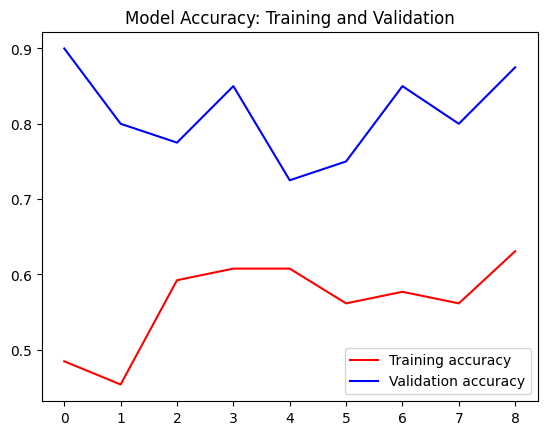

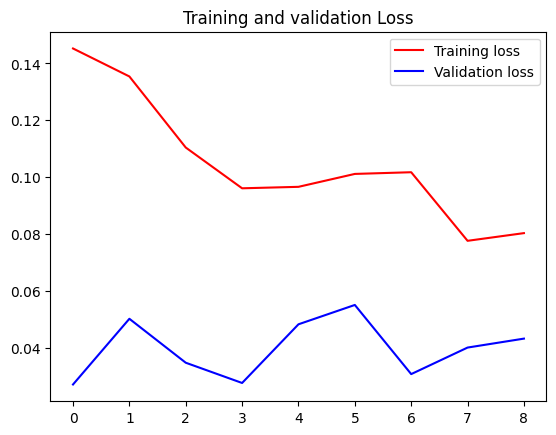

<Figure size 640x480 with 0 Axes>

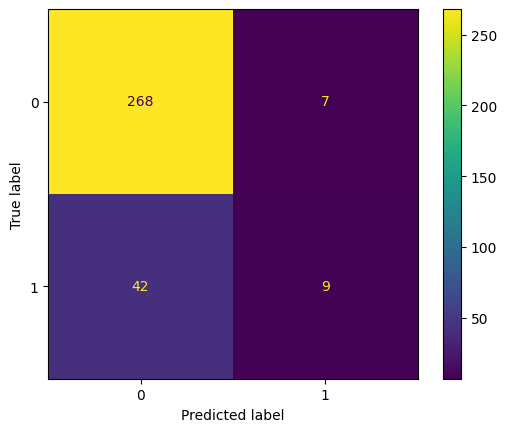


               precision    recall  f1-score   support

           0       0.86      0.97      0.92       275
           1       0.56      0.18      0.27        51

    accuracy                           0.85       326
   macro avg       0.71      0.58      0.59       326
weighted avg       0.82      0.85      0.81       326

Sensitivity: 0.176 Specificity: 0.975 Precision: 0.817 ROC_AUC_SCORE: 0.626



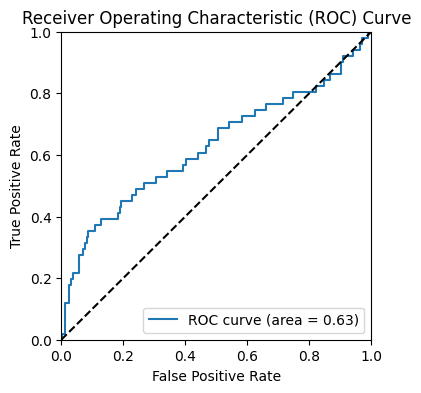

Validation complete...
Traning for Fold: 2
Found 1301 validated image filenames belonging to 2 classes.
Found 325 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/30
14/14 [==============================] - ETA: 0s - loss: 0.1078 - accuracy: 0.5214
Epoch 1: val_accuracy improved from -inf to 0.85000, saving model to /content/drive/MyDrive/msc_project/model/seb_vs_nev_no_aug/model_fold_2.hdf5
14/14 [==============================] - 75s 2s/step - loss: 0.1078 - accuracy: 0.5214 - val_loss: 0.0362 - val_accuracy: 0.8500 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/30
14/14 [==============================] - ETA: 0s - loss: 0.1231 - accuracy: 0.4786
Epoch 2: val_accuracy did not improve from 0.85000
14/14 [==============================] - 15s 1s/step - loss: 0.1231 - accuracy: 0.4786 - val_loss: 0.0440 - val_accuracy: 0.8250 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler

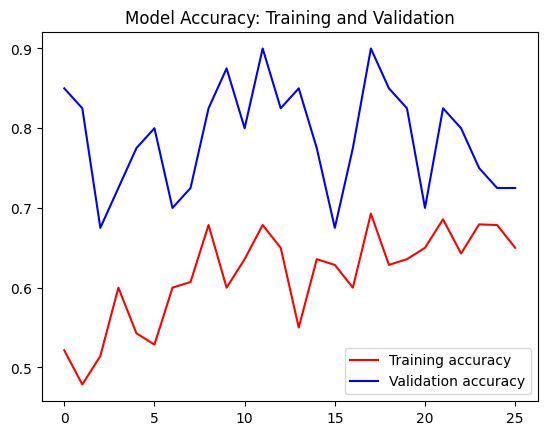

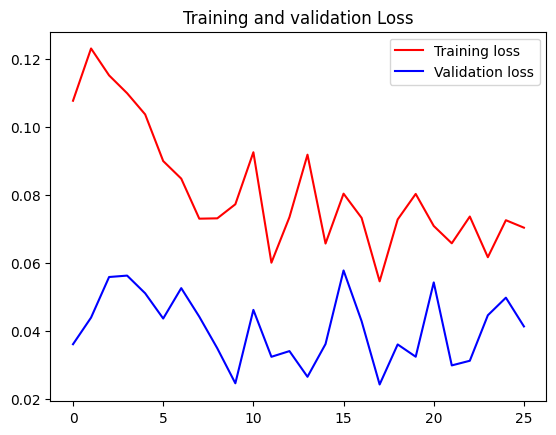

<Figure size 640x480 with 0 Axes>

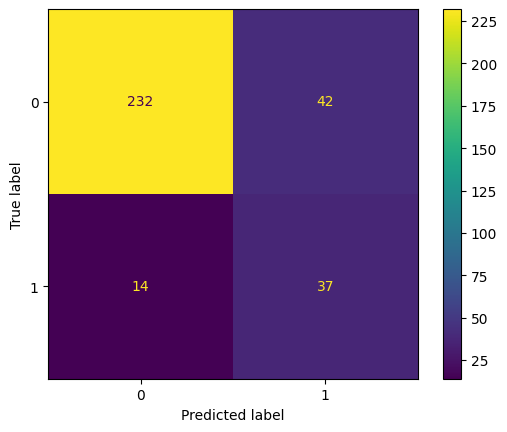


               precision    recall  f1-score   support

           0       0.94      0.85      0.89       274
           1       0.47      0.73      0.57        51

    accuracy                           0.83       325
   macro avg       0.71      0.79      0.73       325
weighted avg       0.87      0.83      0.84       325

Sensitivity: 0.725 Specificity: 0.847 Precision: 0.869 ROC_AUC_SCORE: 0.877



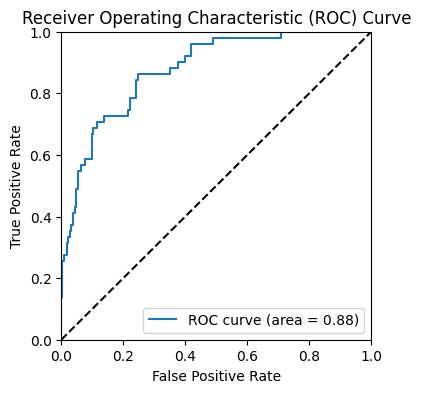

Validation complete...
Traning for Fold: 3
Found 1301 validated image filenames belonging to 2 classes.
Found 325 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/30
14/14 [==============================] - ETA: 0s - loss: 0.0666 - accuracy: 0.6071
Epoch 1: val_accuracy improved from -inf to 0.77500, saving model to /content/drive/MyDrive/msc_project/model/seb_vs_nev_no_aug/model_fold_3.hdf5
14/14 [==============================] - 70s 1s/step - loss: 0.0666 - accuracy: 0.6071 - val_loss: 0.0416 - val_accuracy: 0.7750 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/30
14/14 [==============================] - ETA: 0s - loss: 0.0901 - accuracy: 0.5643
Epoch 2: val_accuracy did not improve from 0.77500
14/14 [==============================] - 8s 565ms/step - loss: 0.0901 - accuracy: 0.5643 - val_loss: 0.0367 - val_accuracy: 0.7750 - lr: 2.0000e-05

Epoch 3: LearningRateSchedul

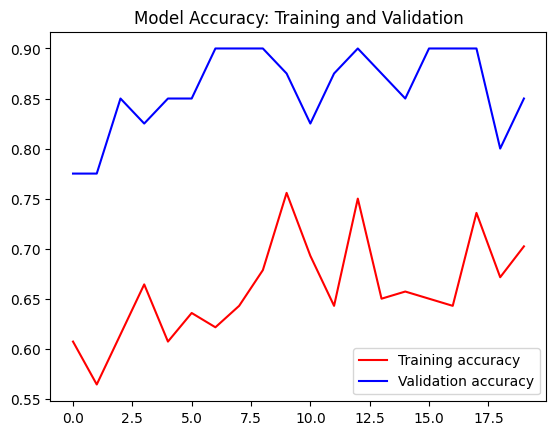

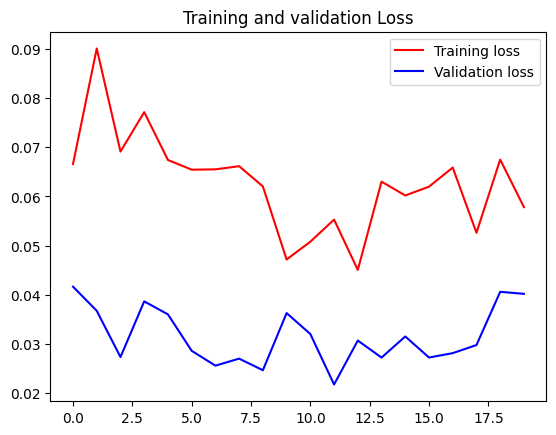

<Figure size 640x480 with 0 Axes>

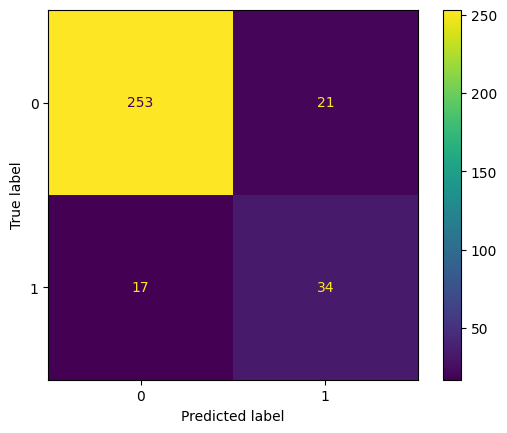


               precision    recall  f1-score   support

           0       0.94      0.92      0.93       274
           1       0.62      0.67      0.64        51

    accuracy                           0.88       325
   macro avg       0.78      0.80      0.79       325
weighted avg       0.89      0.88      0.88       325

Sensitivity: 0.667 Specificity: 0.923 Precision: 0.887 ROC_AUC_SCORE: 0.896



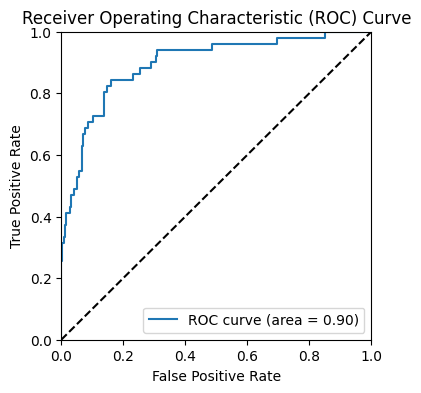

Validation complete...
Traning for Fold: 4
Found 1301 validated image filenames belonging to 2 classes.
Found 325 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/30
14/14 [==============================] - ETA: 0s - loss: 0.0620 - accuracy: 0.6500
Epoch 1: val_accuracy improved from -inf to 0.85000, saving model to /content/drive/MyDrive/msc_project/model/seb_vs_nev_no_aug/model_fold_4.hdf5
14/14 [==============================] - 71s 1s/step - loss: 0.0620 - accuracy: 0.6500 - val_loss: 0.0419 - val_accuracy: 0.8500 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/30
14/14 [==============================] - ETA: 0s - loss: 0.0583 - accuracy: 0.6714
Epoch 2: val_accuracy improved from 0.85000 to 0.87500, saving model to /content/drive/MyDrive/msc_project/model/seb_vs_nev_no_aug/model_fold_4.hdf5
14/14 [==============================] - 14s 1s/step - loss: 0.0583 - accuracy:

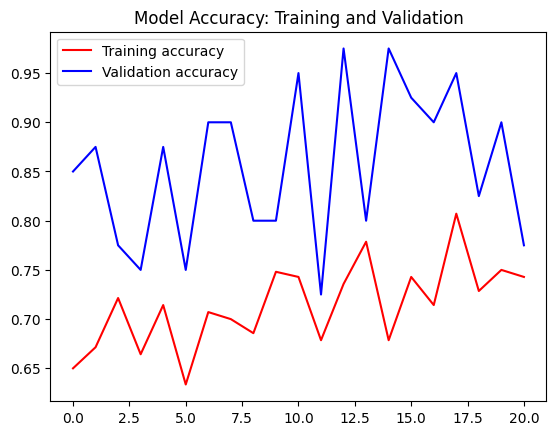

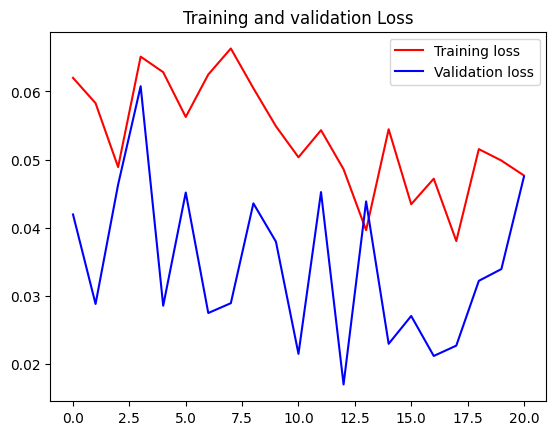

<Figure size 640x480 with 0 Axes>

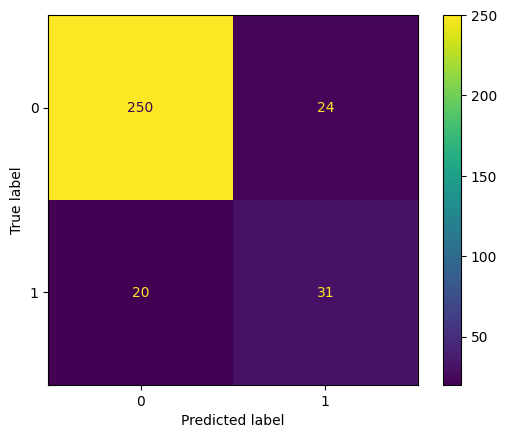


               precision    recall  f1-score   support

           0       0.93      0.91      0.92       274
           1       0.56      0.61      0.58        51

    accuracy                           0.86       325
   macro avg       0.74      0.76      0.75       325
weighted avg       0.87      0.86      0.87       325

Sensitivity: 0.608 Specificity: 0.912 Precision: 0.869 ROC_AUC_SCORE: 0.841



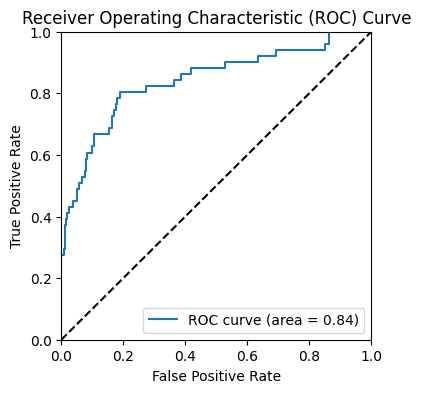

Validation complete...
Traning for Fold: 5
Found 1301 validated image filenames belonging to 2 classes.
Found 325 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/30
14/14 [==============================] - ETA: 0s - loss: 0.0583 - accuracy: 0.6714
Epoch 1: val_accuracy improved from -inf to 0.85000, saving model to /content/drive/MyDrive/msc_project/model/seb_vs_nev_no_aug/model_fold_5.hdf5
14/14 [==============================] - 74s 2s/step - loss: 0.0583 - accuracy: 0.6714 - val_loss: 0.0367 - val_accuracy: 0.8500 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/30
14/14 [==============================] - ETA: 0s - loss: 0.0606 - accuracy: 0.6357
Epoch 2: val_accuracy improved from 0.85000 to 0.87500, saving model to /content/drive/MyDrive/msc_project/model/seb_vs_nev_no_aug/model_fold_5.hdf5
14/14 [==============================] - 14s 1s/step - loss: 0.0606 - accuracy:

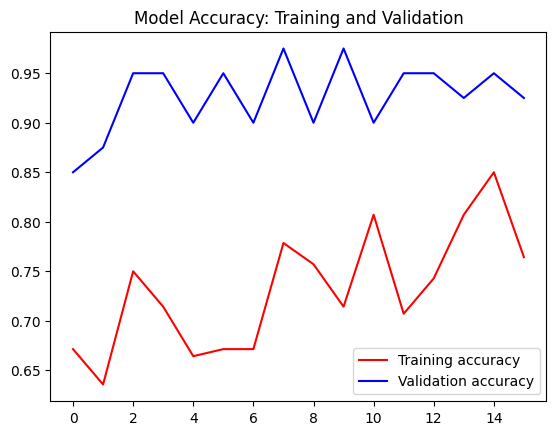

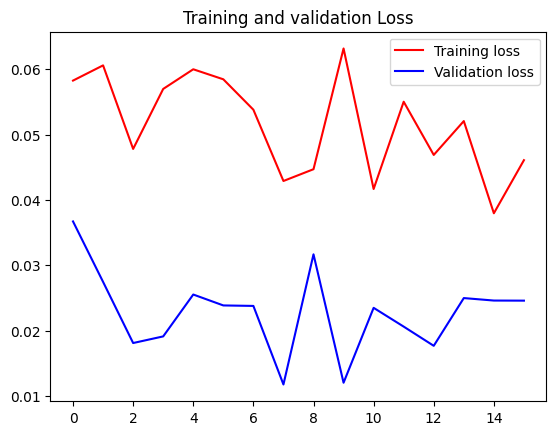

<Figure size 640x480 with 0 Axes>

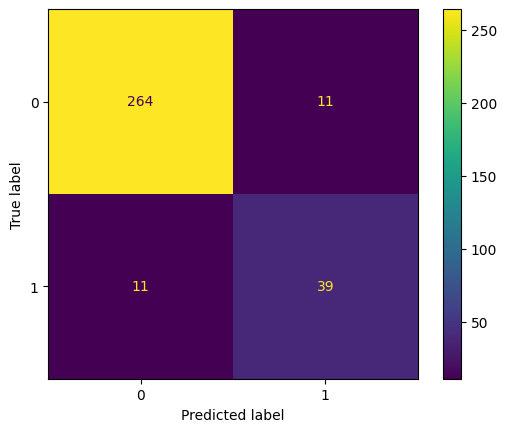


               precision    recall  f1-score   support

           0       0.96      0.96      0.96       275
           1       0.78      0.78      0.78        50

    accuracy                           0.93       325
   macro avg       0.87      0.87      0.87       325
weighted avg       0.93      0.93      0.93       325

Sensitivity: 0.78 Specificity: 0.96 Precision: 0.932 ROC_AUC_SCORE: 0.965



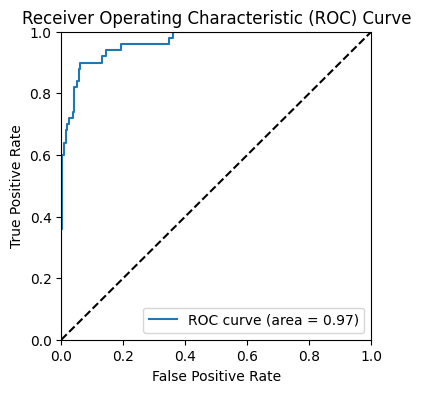

Validation complete...


In [18]:
# Perform k-fold cross-validation
fold = 1
for i, (train_index, val_index) in enumerate(skf.split(train_paths, train_labels)):
    print(f"Traning for Fold: {fold}")
    # Split the data into train and validation sets for this fold
    train_paths_fold, val_paths_fold = train_paths[train_index], train_paths[val_index]
    train_labels_fold, val_labels_fold = train_labels[train_index], train_labels[val_index]

    # Create data generators for this fold
    train_generator_fold = datagen.flow_from_dataframe(
        pd.DataFrame({'filename': train_paths_fold, 'class': train_labels_fold}),
        directory=train_dir,
        x_col='filename',
        y_col='class',
        target_size=image_size,
        batch_size=batch
    )

    val_generator_fold = datagen.flow_from_dataframe(
      pd.DataFrame({'filename': val_paths_fold, 'class': val_labels_fold}),
      directory=train_dir,
      x_col='filename',
      y_col='class',
      target_size=image_size,
      batch_size=batch
  )

    train_steps = np.ceil(len(train_generator_fold) / batch)
    val_steps = np.ceil(len(val_generator_fold) / batch)

    #set path to save model
    checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = model_path + f'/model_fold_{fold}.hdf5',
                                                  monitor = 'val_accuracy',
                                                  verbose = 1,
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')

    callbacks = [early_stopping, checkpointer, lr_scheduler]


    # Compile the model
    model.compile(optimizer='adam', loss=focal_loss(), metrics=['accuracy'])

    # Train the model on the training data and evaluate on the validation data
    history = model.fit(
        train_generator_fold,
        steps_per_epoch=train_steps,
        validation_data=val_generator_fold,
        validation_steps=val_steps,
        epochs=30,
        callbacks=callbacks)

    graph_it(history)


    val_generator_fold_test = datagen.flow_from_dataframe(
        pd.DataFrame({'filename': val_paths_fold, 'class': val_labels_fold}),
        directory=train_dir,
        x_col='filename',
        y_col='class',
        target_size=image_size,
        batch_size=1,
        shuffle=False
    )

    print(f"\nValidating for fold {fold}... \n")
    print("Loading model...")

    model.load_weights(filepath = model_path + f'/model_fold_{fold}.hdf5')
    test_it(model, val_generator_fold_test)

    print("Validation complete...")

    fold += 1


**Model Evaluation using test data**

In [19]:
test_dir

'/content/drive/MyDrive/msc_project/test_splited'

In [20]:
test_generator = datagen.flow_from_directory(
        test_dir,
        target_size=image_size,
        batch_size=1,
        shuffle=False
    )
test_generator.shuffle = False

Found 483 images belonging to 2 classes.


Test using model 1
483/483 [==============================] - 51s 105ms/step


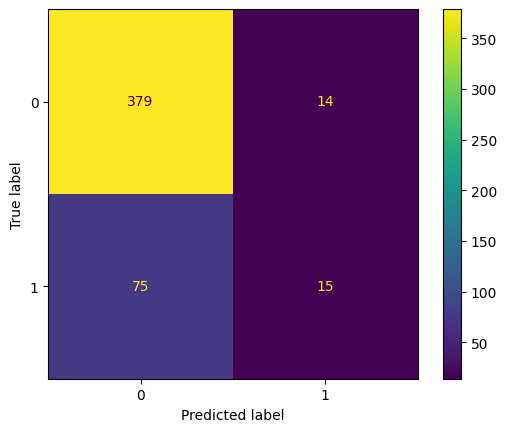


               precision    recall  f1-score   support

           0       0.83      0.96      0.89       393
           1       0.52      0.17      0.25        90

    accuracy                           0.82       483
   macro avg       0.68      0.57      0.57       483
weighted avg       0.78      0.82      0.78       483

Sensitivity: 0.167 Specificity: 0.964 Precision: 0.776 ROC_AUC_SCORE: 0.562



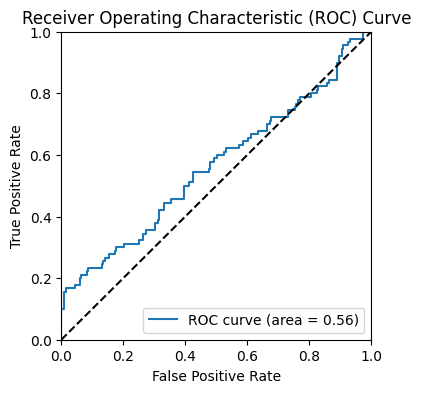

Testing Complete
Test using model 2
483/483 [==============================] - 20s 42ms/step


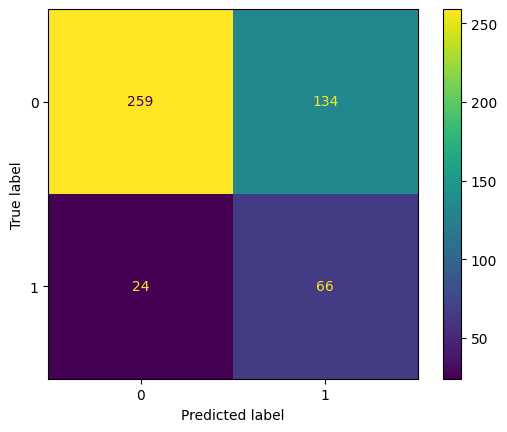


               precision    recall  f1-score   support

           0       0.92      0.66      0.77       393
           1       0.33      0.73      0.46        90

    accuracy                           0.67       483
   macro avg       0.62      0.70      0.61       483
weighted avg       0.81      0.67      0.71       483

Sensitivity: 0.733 Specificity: 0.659 Precision: 0.806 ROC_AUC_SCORE: 0.778



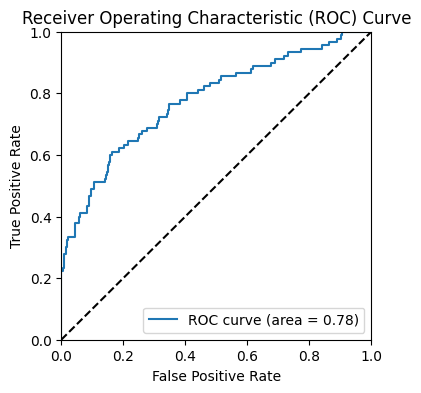

Testing Complete
Test using model 3
483/483 [==============================] - 22s 45ms/step


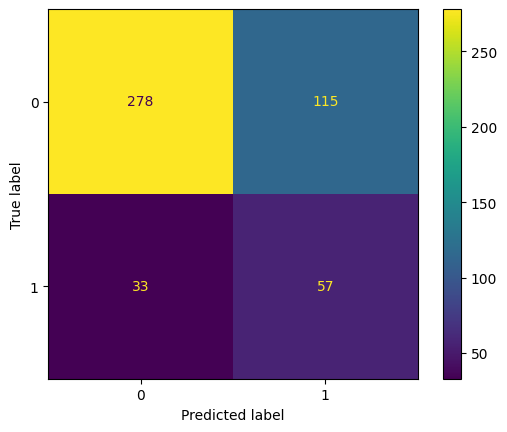


               precision    recall  f1-score   support

           0       0.89      0.71      0.79       393
           1       0.33      0.63      0.44        90

    accuracy                           0.69       483
   macro avg       0.61      0.67      0.61       483
weighted avg       0.79      0.69      0.72       483

Sensitivity: 0.633 Specificity: 0.707 Precision: 0.789 ROC_AUC_SCORE: 0.734



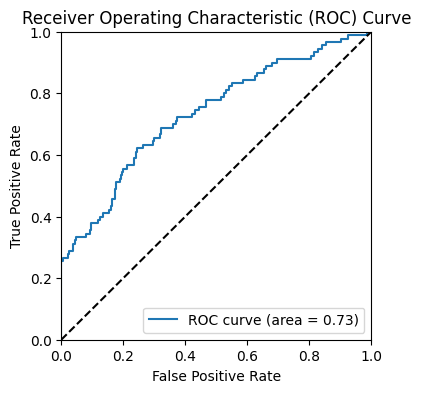

Testing Complete
Test using model 4
483/483 [==============================] - 22s 45ms/step


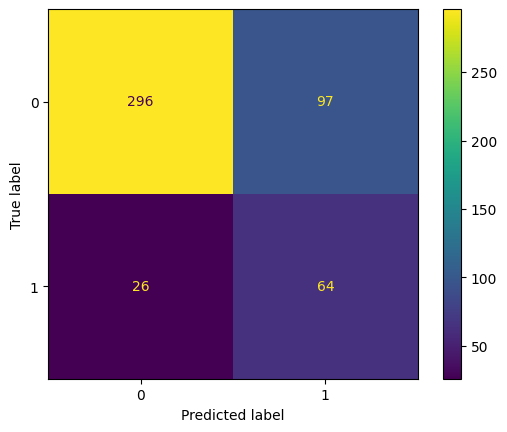


               precision    recall  f1-score   support

           0       0.92      0.75      0.83       393
           1       0.40      0.71      0.51        90

    accuracy                           0.75       483
   macro avg       0.66      0.73      0.67       483
weighted avg       0.82      0.75      0.77       483

Sensitivity: 0.711 Specificity: 0.753 Precision: 0.822 ROC_AUC_SCORE: 0.789



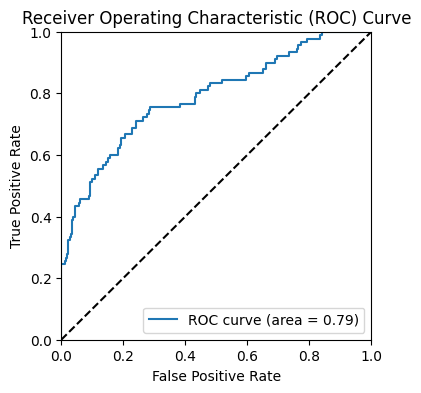

Testing Complete
Test using model 5
483/483 [==============================] - 23s 47ms/step


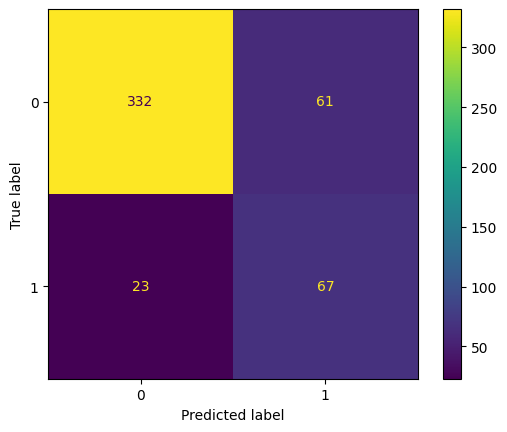


               precision    recall  f1-score   support

           0       0.94      0.84      0.89       393
           1       0.52      0.74      0.61        90

    accuracy                           0.83       483
   macro avg       0.73      0.79      0.75       483
weighted avg       0.86      0.83      0.84       483

Sensitivity: 0.744 Specificity: 0.845 Precision: 0.858 ROC_AUC_SCORE: 0.89



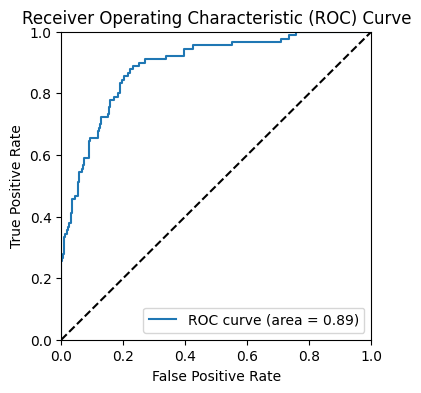

Testing Complete


In [21]:
#set path to best weights from your training please manually! {title}_fold_{fold}
for i in range(1, num_fold + 1):
  print(f"Test using model {i}")
  model.load_weights(filepath = model_path + f'/model_fold_{i}.hdf5')
  test_it(model, test_generator)
  print("Testing Complete")